# Step 6: Outlier Detection and Removal

Outliers can significantly impact the performance of machine learning models. Detecting and removing them is an essential step in data preprocessing to ensure models are not skewed by extreme values.

---

## Table of Contents

1. [Introduction to Outliers](#1-introduction-to-outliers)
2. [Visualizing Outliers](#2-visualizing-outliers)
3. [Z-Score Method](#3-z-score-method)
4. [Interquartile Range (IQR) Method](#4-interquartile-range-iqr-method)
5. [Isolation Forest](#5-isolation-forest)
6. [Removing Outliers](#6-removing-outliers)

---

## 1. Introduction to Outliers

Outliers are data points that significantly differ from other observations. These can distort statistical analyses and model predictions.

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('categorical_data.csv')
data.drop(columns=["ID"],inplace=True)
data.describe()

,Price,Sales,Discount_Percentage,Customer_Rating
count,200.000000,200.000000,200.000000,200.000000
mean,486.066750,5031.065000,23.856450,2.946500
std,274.369629,2821.302225,14.181106,1.162128
min,15.990000,133.000000,0.070000,1.000000
25%,261.710000,2549.750000,12.900000,1.900000
50%,488.695000,5363.500000,25.440000,3.000000
75%,694.670000,7452.500000,34.785000,4.000000
max,992.510000,9827.000000,49.360000,5.000000


Outliers are generally indicated by values that lie far outside the range of the majority of data points.

## 2. Visualizing Outliers

['Price', 'Sales', 'Discount_Percentage', 'Customer_Rating']


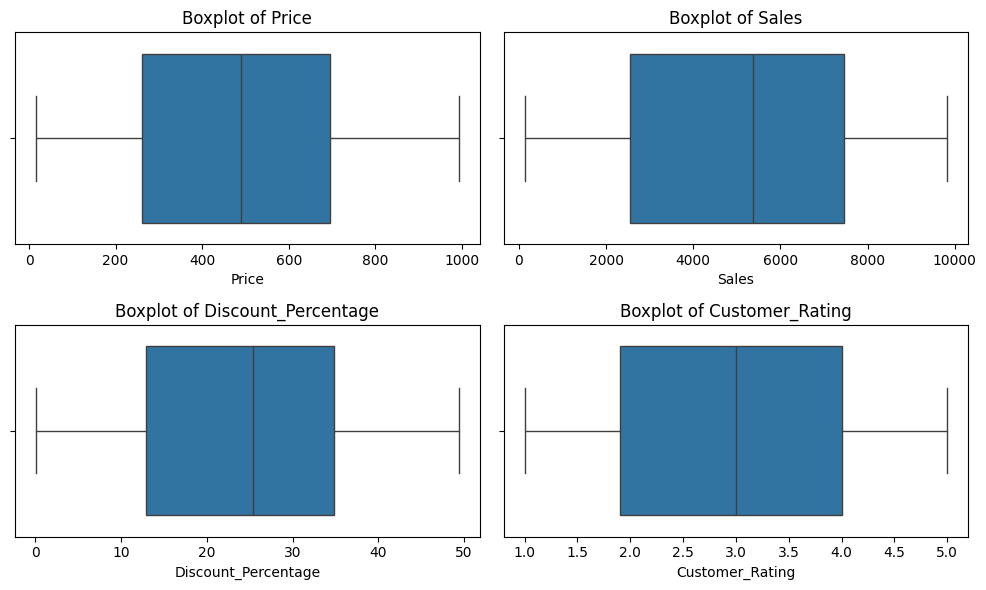

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols =  data.select_dtypes(include=["int64","float64"]).columns.tolist()
plt.figure(figsize=(10,6))

for i,col in enumerate(num_cols,1):
    plt.subplot(2,2,i) # 2,2 is according to number of numerical columns
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    
plt.tight_layout()
plt.show()

Boxplots are a simple way to visualize outliers. Points beyond the whiskers are considered potential outliers.

## 3. Z-Score Method

The Z-Score measures how many standard deviations a data point is from the mean. Typically, data points with Z-scores above 3 or below -3 are considered outliers.

In [8]:
from scipy.stats import zscore

z_scores = np.abs(zscore(data[num_cols]))
print("Z-Scores:\n", z_scores)

Z-Scores:
         Price     Sales  Discount_Percentage  Customer_Rating
0    1.403863  0.504554             0.706682         1.340127
1    0.142732  0.964358             1.109429         0.563742
2    1.182147  1.159793             1.385133         0.298908
3    1.707317  0.847453             1.795861         0.902763
4    0.446856  1.549241             0.334128         0.816498
..        ...       ...                  ...              ...
195  0.435041  0.684755             0.482379         0.212643
196  1.600368  0.294596             0.644472         0.040113
197  1.659926  1.020146             0.143963         0.563742
198  0.213982  1.406396             0.241315         0.304947
199  1.321591  0.824757             0.628008         1.253862

[200 rows x 4 columns]


In [11]:
# Try this with another thresholds 
threshold = 3 
outliers_zscore = np.where(z_scores>threshold)

print("Outlier indices using Z-score:", outliers_zscore)

Outlier indices using Z-score: (array([], dtype=int64), array([], dtype=int64))


Z-score method is effective when data is normally distributed. Data points with Z-scores greater than 3 or less than -3 are often outliers.

## 4. Interquartile Range (IQR) Method

The IQR method is another popular way to detect outliers by identifying values that fall outside the range of 1.5 times the IQR.

In [21]:
# Try this with another thresholds 
threshold = 1.5

Q1 = data[num_cols].quantile(.25)
Q3 = data[num_cols].quantile(.75)
IQR = Q3-Q1

outliers_iqr = ((data[num_cols]<(Q1-threshold*IQR)) | (data[num_cols]>(Q3+threshold*IQR)))
print("Outliers using IQR method:\n", outliers_iqr)

Outliers using IQR method:
      Price  Sales  Discount_Percentage  Customer_Rating
0    False  False                False            False
1    False  False                False            False
2    False  False                False            False
3    False  False                False            False
4    False  False                False            False
..     ...    ...                  ...              ...
195  False  False                False            False
196  False  False                False            False
197  False  False                False            False
198  False  False                False            False
199  False  False                False            False

[200 rows x 4 columns]


The IQR method works well for non-normally distributed data or datasets with skewed distributions.

## 5. Isolation Forest

In [22]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination = .05,random_state =42)
outliers_iso = iso_forest.fit_predict(data[num_cols])

data["Outlier"] = outliers_iso

outliers_detected = data[data['Outlier'] == -1]
print("Outliers detected using Isolation Forest:\n", outliers_detected)

Outliers detected using Isolation Forest:
     Product_Name     Category Region   Price  Sales  Discount_Percentage  \
3      Product_4        Books  South  953.33   7416                49.26   
42    Product_43  Electronics   West  988.30   7172                48.90   
48    Product_49     Clothing   East  329.31   1002                49.36   
106  Product_107        Books  North   16.50   5752                37.25   
109  Product_110  Electronics  South  898.04    196                31.09   
114  Product_115    Furniture  South  968.46   7126                45.32   
142  Product_143    Furniture   East  680.76   3088                 2.62   
168  Product_169         Food  South   87.96    375                 2.21   
171  Product_172        Books   East  139.62   9827                 8.11   
177  Product_178     Clothing   East   37.85    413                44.61   

     Customer_Rating  Outlier  
3                1.9       -1  
42               3.5       -1  
48               4.6    

Isolation Forest is highly effective for datasets with complex patterns and high-dimensional data.

## 6. Removing Outliers

Once outliers have been detected, they can be removed to improve model performance.

In [23]:
data_cleaned = data[(z_scores <3).all(axis=1)]
data_cleaned_iqr = data[~((data[num_cols] < (Q1 - 1.5 * IQR)) | (data[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Cleaned data using Z-Score method:\n", data_cleaned.head())
print("\nCleaned data using IQR method:\n", data_cleaned_iqr.head())

Cleaned data using Z-Score method:
   Product_Name   Category Region   Price  Sales  Discount_Percentage  \
0    Product_1  Furniture  South  870.28   6451                13.86   
1    Product_2      Books  South  525.13   7745                39.55   
2    Product_3  Furniture   West  809.60   8295                43.45   
3    Product_4      Books  South  953.33   7416                49.26   
4    Product_5       Food  North  363.77   9391                19.13   

   Customer_Rating  Outlier  
0              4.5        1  
1              3.6        1  
2              2.6        1  
3              1.9       -1  
4              2.0        1  

Cleaned data using IQR method:
   Product_Name   Category Region   Price  Sales  Discount_Percentage  \
0    Product_1  Furniture  South  870.28   6451                13.86   
1    Product_2      Books  South  525.13   7745                39.55   
2    Product_3  Furniture   West  809.60   8295                43.45   
3    Product_4      Books  Sou